# Data

the kasteren dataset is used

In [1]:
import sys
sys.path.append("../..")
import pyadlml.dataset.kasteren as kasteren
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate

In [2]:
sensorData = "/home/chris/code/adlml/datasets/kasteren/kasterenSenseData.txt"
activityData = "/home/chris/code/adlml/datasets/kasteren/kasterenActData.txt"

data = kasteren.load(sensorData, activityData)

/home/chris/Desktop/code/adlml/pyadlml/venv_pyadml/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
../../pyadlml/dataset/devices.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_end['pairs'] = df_end.groupby(['device'])['ones'].apply(lambda x: x.cumsum())
../../pyadlml/dataset/devices.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:

In [3]:
from pyadlml.preprocessing import RawEncoder
from pyadlml.preprocessing import LabelEncoder

t_res = None
idle = True
st='int_coverage'

enc_raw = RawEncoder(t_res=t_res, sample_strat=st)
raw = enc_raw.fit_transform(data.df_devices)

enc_lbl = LabelEncoder(raw, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

In [4]:
# label the activities and drop the duplicates
raw['activities'] = lbls
raw = raw.reset_index(drop=True)
raw = raw.drop_duplicates()
raw = raw.reset_index(drop=True)
raw

,Hall-Bedroom door,Hall-Toilet door,Hall-Bathroom door,ToiletFlush,Plates cupboard,Fridge,Microwave,Groceries Cupboard,Dishwasher,Pans Cupboard,Cups cupboard,Frontdoor,Freezer,Washingmachine,activities
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,2
3,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2
4,1,0,0,1,0,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,1,1,1,1,0,0,0,0,0,0,0,0,0,0,7
287,1,1,0,0,0,0,0,0,0,0,1,0,0,0,2
288,1,0,0,0,1,0,0,0,0,0,0,0,1,0,4
289,1,1,0,0,0,1,0,1,0,0,0,0,0,0,2


In [5]:
lbls = raw['activities']

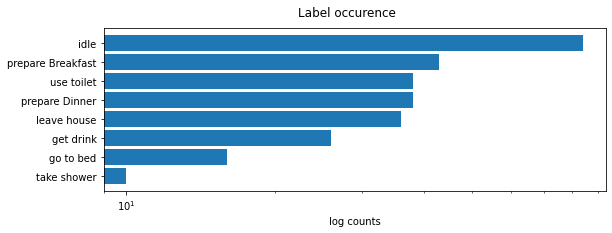

In [6]:
from pyadlml.dataset.plot.raw import hist_activities

hist_activities(enc_lbl.inverse_transform(lbls), scale='log')

The dataset is imbalanced as the labels aren't distributed equally between the classes. 
https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.NearMiss.html#imblearn.under_sampling.NearMiss


In [7]:
from imblearn.under_sampling import RandomUnderSampler

st = 'not minority' # resample all but minority
#st = 'not majority' # resample all but majority
X = raw.iloc[:,:-1].astype(int).values
y = lbls.values

undersample = RandomUnderSampler(sampling_strategy=st)
X_u, y_u = undersample.fit_resample(X,y)

(80, 14)


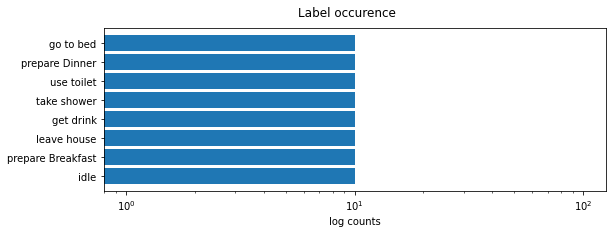

In [8]:
print(X_u.shape)
hist_activities(enc_lbl.inverse_transform(y_u), scale='log')

In [9]:
from pyadlml.preprocessing import RawEncoder
from pyadlml.preprocessing import LabelEncoder

#t_res = '10s'
t_res = None
idle = True
st='int_coverage'

enc_raw = RawEncoder(t_res=t_res, sample_strat=st)
raw = enc_raw.fit_transform(data.df_devices)

enc_lbl = LabelEncoder(raw, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

In [10]:
from pyadlml.model_selection import LeaveOneDayOut

lodo = LeaveOneDayOut(num_days=1)
ts = lodo.split(X=raw, y=lbls)

X = raw
y = lbls

for train_index, test_index in ts:
    X_train, X_test = X.iloc[train_index].values, X.iloc[test_index].values
    y_train = y.iloc[train_index].values.ravel()
    y_test = y.iloc[test_index].values.ravel()

# Model: Decision Tree

# SVMs

# Naive Bayes

In [11]:
from sklearn.naive_bayes import BernoulliNB

steps = []

# 1. resample the data because of the labels
undersample = RandomUnderSampler()
steps.append(('under', undersample))

# 2. Model: Bernoulli Naive Bayes
model = BernoulliNB()
steps.append(('model', model))
pipe = Pipeline(steps=steps)

# evaluate pipeline
n = 10
scoring_fcts = ['f1_macro']#, 'accuracy', 'recall']
param_grid = {
    'under__sampling_strategy' : ['not majority'],
    'model__alpha' : [0.1, 1.0, 10.0], # smoothing parameter
    # class priors (can be used from site)
}

scores = np.zeros(n, dtype=np.float32)
best_param = (0.0, {})
for i in range(n):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
    gscv = GridSearchCV(pipe, param_grid, refit='f1_macro', 
                        scoring=scoring_fcts, cv=cv, n_jobs=-1)

    gscv.fit(X_train, y_train)
    scores[i] = gscv.best_score_
    if scores[i] > best_param[0]:
        best_param = ((scores[i], gscv.best_params_))

In [12]:
print('F1 mean Score: {:.4f}, std: {:.4f}'.format(scores.mean(), scores.std()))
print('F1 best Score: {:.4f}'.format(best_param[0]))

F1 mean Score: 0.2806, std: 0.0045
F1 best Score: 0.2878


In [13]:
best_pipe = Pipeline(steps=steps)
best_pipe = best_pipe.set_params(**best_param[1])
best_pipe = best_pipe.fit(X_train, y_train)
best_model = best_pipe.get_params()['model']

In [14]:
best_model

BernoulliNB(alpha=0.1)

In [15]:
from sklearn.dummy import DummyClassifier

strat='stratified'
strat='most_frequent'
strat='uniform'

dclf = DummyClassifier(strategy=strat).fit(X_train, y_train)

dclf.score(X_test, y_test)

0.15841584158415842

In [16]:
dclf.class_prior_

array([0.04168321, 0.0813815 , 0.23779277, 0.13537118, 0.08217547,
       0.09964272, 0.046447  , 0.27550615])

In [17]:
enc_lbl.inverse_transform(dclf.classes_)

array(['get drink', 'go to bed', 'idle', 'leave house',
       'prepare Breakfast', 'prepare Dinner', 'take shower', 'use toilet'],
      dtype=object)

### confusion matrix

In [18]:
from sklearn.metrics import confusion_matrix

y_true = y_test
y_pred = best_model.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[ 5,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  3,  0,  0,  0,  3],
       [ 0,  0,  0,  2,  6,  0, 12],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  9],
       [ 2,  0,  0,  0,  0,  0, 49]])

In [20]:
from sklearn.metrics import plot_confusion_matrix
#plot_confusion_matrix(best_model, X_test, y_test)

In [21]:
from sklearn.metrics import classification_report

y_true = y_test
y_pred = best_model.predict(X_test)
confusion_matrix(y_true, y_pred)

array([[ 5,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  0,  0,  0,  0,  5],
       [ 0,  0,  3,  0,  0,  0,  3],
       [ 0,  0,  0,  2,  6,  0, 12],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  9],
       [ 2,  0,  0,  0,  0,  0, 49]])

In [28]:
from pyadlml.model_selection import LeaveOneDayOut

lodo = LeaveOneDayOut(num_days=1)
ts = lodo.split(X=raw, y=lbls)

X = raw
y = lbls

for train_index, test_index in ts:
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]
    
from sklearn.dummy import DummyClassifier

strat='stratified'

dclf = DummyClassifier(strategy=strat).fit(X_train, y_train)
y_pred = dclf.predict(X_test)
y_true = enc_lbl.inverse_transform(y_test)

In [29]:
enc_lbl = LabelEncoder(raw, idle=idle)
lbls = enc_lbl.fit_transform(data.df_activities)

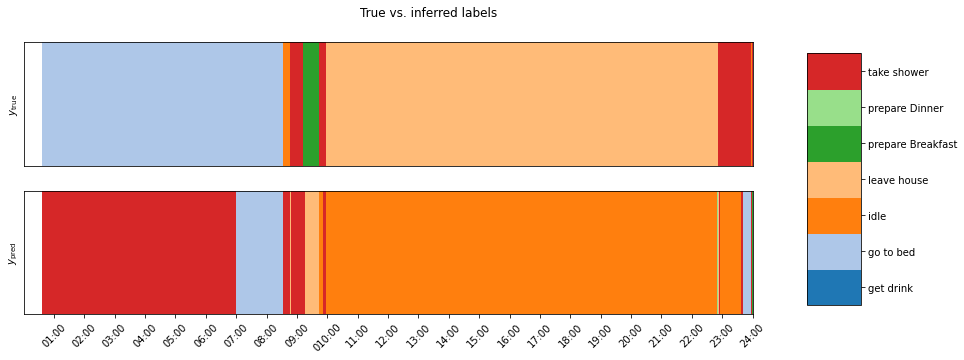

In [30]:
from pyadlml.metrics import plot_true_vs_inf_y
plot_true_vs_inf_y(enc_lbl, y_true, y_pred, index=y_true.index)

In [34]:
y_true.head(50)

time
2008-03-20 00:34:38            go to bed
2008-03-20 00:34:39            go to bed
2008-03-20 00:34:42            go to bed
2008-03-20 00:35:10           use toilet
2008-03-20 00:35:13           use toilet
2008-03-20 00:35:39           use toilet
2008-03-20 00:35:40           use toilet
2008-03-20 00:35:43           use toilet
2008-03-20 00:35:44           use toilet
2008-03-20 00:35:45           use toilet
2008-03-20 00:35:59           use toilet
2008-03-20 00:36:17            go to bed
2008-03-20 06:57:51            go to bed
2008-03-20 06:57:52            go to bed
2008-03-20 06:57:55           use toilet
2008-03-20 06:57:56           use toilet
2008-03-20 06:57:57           use toilet
2008-03-20 06:57:58           use toilet
2008-03-20 06:58:15           use toilet
2008-03-20 06:58:31           use toilet
2008-03-20 06:58:32           use toilet
2008-03-20 06:58:33           use toilet
2008-03-20 06:58:37           use toilet
2008-03-20 06:58:43            go to bed
2008-03-20 

In [26]:
y_pred

array([5, 3, 1, 7, 2, 5, 6, 2, 7, 3, 7, 0, 7, 6, 2, 5, 7, 3, 2, 0, 5, 5,
       7, 2, 6, 0, 5, 4, 3, 4, 2, 4, 3, 7, 5, 7, 4, 7, 4, 3, 7, 7, 1, 7,
       7, 7, 3, 2, 4, 7, 7, 4, 6])